# Programa Ejemplo para la sintonización de hiperparámetros en redes neuronales.

## Etapa 1: Carga de los datos.

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para este ejemplo, usaremos la base de datos MNIST, la cual consiste en identificar dígitos escritos a mano alzada https://keras.io/api/datasets/mnist/. Esta base de datos configura un problema de 10 clases, una clase por cada dígito numérico (0-9).

Se cargan las librerías necesarias

In [2]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.3 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from keras_tuner import RandomSearch

Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Se divide el train en validation

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

In [6]:

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(54000, 28, 28) (54000,) (6000, 28, 28) (6000,)


Las imágenes tienen tamaño 28x28. A continuación de muestran algunos ejemplos.


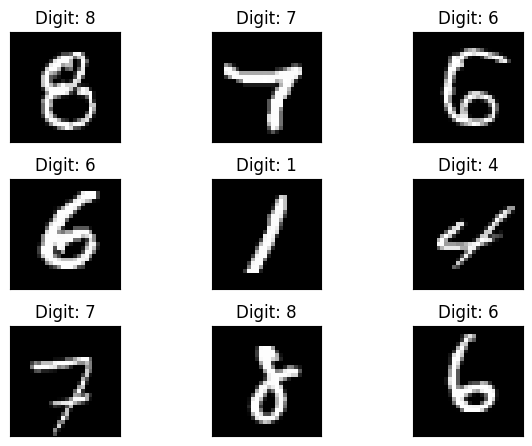

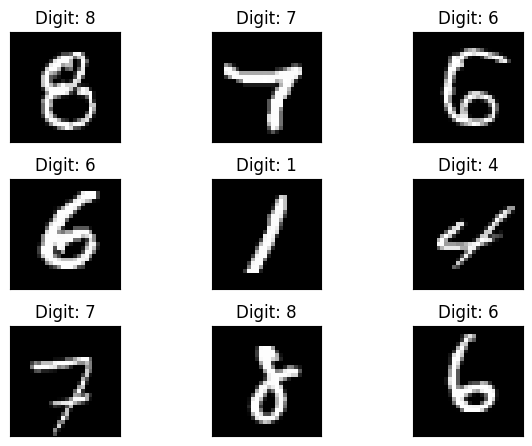

In [7]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [8]:
d1, d2, d3 = x_train.shape
x_train_flat = x_train.reshape((d1, d2*d3))/255
d1, d2, d3 = x_test.shape
x_test_flat = x_test.reshape((d1, d2*d3))/255
d1, d2, d3 = x_val.shape
x_val_flat = x_val.reshape((d1, d2 * d3)) / 255

print(x_train_flat.shape, x_test_flat.shape, x_val_flat.shape)

(54000, 784) (10000, 784) (6000, 784)



# Búsqueda de hiperparámetros a partir de la búsqueda aleatoria

Ejemplo avanzado donde el número de capas también se trata como un hiperparámetro

In [9]:
# Número de épocas para los experimentos
epochs = 10

In [10]:
def build_model_1(hp):
  model = Sequential()
  for i in range(hp.Int('num_layers', 1, 3, 1)): # range(2)
    model.add(Dense(units = hp.Choice('units'+str(i+1), [256, 512]), activation = hp.Choice('activation'+str(i+1), ['relu', 'sigmoid'])))   
  model.add(Dense(10, activation = 'softmax'))
  optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001]))
  model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [11]:
tuner_1 = RandomSearch(build_model_1, objective = 'val_loss', max_trials = 10)
tuner_1.search(x_train_flat, y_train, epochs = epochs, validation_data = (x_val_flat, y_val), verbose=2)
best_model_1 = tuner_1.get_best_models()[0]

Trial 10 Complete [00h 00m 59s]
val_loss: 0.15911944210529327

Best val_loss So Far: 0.08032485097646713
Total elapsed time: 00h 11m 23s


In [12]:
print(best_model_1.layers[0].units, best_model_1.layers[1].units, best_model_1.layers[2].units)
print(best_model_1.layers[0].activation, best_model_1.layers[1].activation)
print(best_model_1.optimizer.learning_rate)

256 256 10
<function relu at 0x7efff3756280> <function sigmoid at 0x7efff3756790>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [13]:
test_loss, test_acc = best_model_1.evaluate(x_test_flat, y_test)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0713 - accuracy: 0.9781
test_acc: 0.9781000018119812
